In [ ]:
# !wget -P pictures/ https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz

In [ ]:
# !tar -xzvf pictures/102flowers.tgz -C "/content/gdrive/MyDrive/AIRoshan/pictures/"

In [ ]:
import random
from keras import backend as K
import matplotlib.pyplot as plt
from PIL import Image as pImage
from keras.models import Model
from tensorflow.keras.preprocessing import image as kImage
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib.pyplot import figure
import json
import scipy.io
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, Input, Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf
import pickle
import pandas as pd
from keras_preprocessing.image import ImageDataGenerator
from keras import regularizers, optimizers
from keras import losses

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
BASE_ADDRESS = '/content/gdrive/MyDrive/AIRoshan/pictures/jpg'

In [ ]:
!wget -P pictures/ https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat

--2022-08-19 09:32:49--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 502
Saving to: ‘pictures/imagelabels.mat’

imagelabels.mat     100%[===================>]     502  --.-KB/s    in 0s      

2022-08-19 09:32:50 (12.3 MB/s) - ‘pictures/imagelabels.mat’ saved [502/502]



In [ ]:
mat = scipy.io.loadmat('pictures/imagelabels.mat')
labels = mat['labels'][0]
unique, counts = np.unique(labels, return_counts=True)

In [ ]:
def makeImagePath(imgNumber):
    imgNumber = str(imgNumber)
    while(len(imgNumber) < 5):
        imgNumber = '0' + imgNumber
    imagePath = f'image_{imgNumber}.jpg'
    return imagePath

In [ ]:
data = {
  'fileName': list(range(1, labels.shape[0] + 1)),
  'label': labels.tolist()
}

all_df = pd.DataFrame(data)
all_df['fileName'] = all_df['fileName'].apply(makeImagePath)
all_df['label'] = all_df['label']
all_df.head()

,fileName,label
0,image_00001.jpg,77
1,image_00002.jpg,77
2,image_00003.jpg,77
3,image_00004.jpg,77
4,image_00005.jpg,77


In [ ]:
test_classes = list(range(1, 20))

test_df = all_df[all_df['label'].isin(test_classes)]
train_df = all_df.drop(test_df.index)
train_df['label'] = train_df['label'] - 20
val_df = train_df.sample(frac=0.2, random_state=42)
train_df = train_df.drop(val_df.index)

train_df = train_df.sample(frac=1, random_state=42)
val_df = val_df.sample(frac=1, random_state=42)

In [ ]:
test_df.reset_index(inplace=True)
train_df.reset_index(inplace=True)
val_df.reset_index(inplace=True)

In [ ]:
val_df['label'].min()

0

In [ ]:
labels[1746 -1]

83

In [ ]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_dataframe(
dataframe=train_df,
directory=BASE_ADDRESS,
x_col="fileName",
y_col="label",
subset="training",
batch_size=128,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(80,80))

valid_generator=datagen.flow_from_dataframe(
dataframe=train_df,
directory=BASE_ADDRESS,
x_col="fileName",
y_col="label",
subset="validation",
batch_size=128,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(80,80))

Found 5672 validated image filenames belonging to 83 classes.
Found 1418 validated image filenames belonging to 83 classes.


In [ ]:
X, y = valid_generator.next()

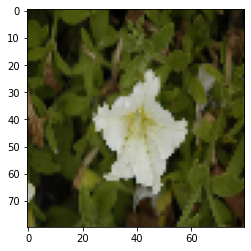

In [ ]:
plt.imshow(X[7])

In [ ]:
test_datagen=ImageDataGenerator(rescale=1./255)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test_df,
directory=BASE_ADDRESS,
x_col="fileName",
y_col=None,
batch_size=1,
seed=42,
shuffle=False,
class_mode=None,
target_size=(500,500))

Found 1099 validated image filenames.


In [ ]:
# base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(500, 500, 3))

# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# # x = Flatten(x)
# x = Dense(512, activation='relu')(x)
# # x = Dropout(0.5)(x)
# # x = Dense(316, activation='relu')(x)
# predictions = Dense(83, activation='softmax')(x)
# model = Model(inputs=base_model.input, outputs=predictions)

# for layer in base_model.layers:
#     layer.trainable = False

# model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
class CustomDataGen(tf.keras.utils.Sequence):

    def __init__(self, df, directory, X_col, y_col, batch_size, seed, shuffle, target_size=(100, 100), rescale=1./255.):
        self.df = df.copy()
        self.directory = directory
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.seed = seed
        self.shuffle = shuffle
        self.target_size = target_size
        self.rescale = rescale

        self.n = len(self.df)
        self.n_classes = df['label'].nunique()

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self, index):
        batch = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batch)
        return X, y

    def on_epoche_end(self):
        if self.shuffle:
          self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __get_data(self, batch):
      pathes = batch[self.X_col]
      labels = batch[self.y_col]

      X_batch_img = np.asarray([self.__get_input_img(path) for path in pathes])
      X_batch_labels = np.asarray([self.__get_label(label) for label in labels])

      y_batch_labels = np.asarray([self.__get_label(label) for label in labels])
      y_batch_dummy = np.zeros((y_batch_labels.shape[0], 1))

      return tuple([X_batch_img, X_batch_labels]), tuple([y_batch_labels, y_batch_dummy])

    def __get_input_img(self, path):
        image = tf.keras.preprocessing.image.load_img(f'{BASE_ADDRESS}/{path}')
        image_arr = tf.keras.preprocessing.image.img_to_array(image)

        image_arr = tf.image.resize(image_arr, self.target_size).numpy()

        return image_arr * self.rescale

    def __get_label(self, label):
      return tf.keras.utils.to_categorical(label, num_classes=self.n_classes)

In [ ]:
batch_size = 128

train_gen = CustomDataGen(train_df,
                          X_col='fileName',
                          directory=BASE_ADDRESS,
                          y_col='label',
                          batch_size=batch_size,
                          seed=42,
                          shuffle=True
    )

val_gen = CustomDataGen( val_df,
                         directory=BASE_ADDRESS,
                         X_col='fileName',
                         y_col='label',
                         batch_size=batch_size,
                         seed=42,
                         shuffle=True
    )

In [ ]:
# base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(500, 500, 3))
base_model = ResNet50(include_top=False,weights='imagenet',input_shape=(100,100,3),classes=83)

In [ ]:
model=Sequential()
#Add the Dense layers along with activation and batch normalization
model.add(base_model)
model.add(Flatten())


#Add the Dense layers along with activation and batch normalization
model.add(Dense(4000,activation=('relu'),input_dim=512))
model.add(Dense(2000,activation=('relu')))
model.add(Dropout(.4))
model.add(Dense(1000,activation=('relu')))
model.add(Dropout(.3))#Adding a dropout layer that will randomly drop 30% of the weights
model.add(Dense(500,activation=('relu')))
model.add(Dropout(.2))
model.add(Dense(83,activation=('softmax'))) #

# not sequential model

In [ ]:
class CenterLossLayer(Layer):

    def __init__(self, alpha=0.5, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha

    def build(self, input_shape):
        self.centers = self.add_weight(name='centers',
                                       shape=(83, 500),
                                       initializer='uniform',
                                       trainable=False)
        super().build(input_shape)

    def call(self, x, mask=None):

        # x[0] is Nx2, x[1] is Nx10 onehot, self.centers is 10x2
        delta_centers = K.dot(K.transpose(x[1]), (K.dot(x[1], self.centers) - x[0]))  # 10x2
        center_counts = K.sum(K.transpose(x[1]), axis=1, keepdims=True) + 1  # 10x1
        delta_centers /= center_counts
        new_centers = self.centers - self.alpha * delta_centers
        self.add_update((self.centers, new_centers), x)

        self.result = x[0] - K.dot(x[1], self.centers)
        self.result = K.sum(self.result ** 2, axis=1, keepdims=True) / 500 #/ K.dot(x[1], center_counts)
        print(self.centers)
        print(self.result)
        return self.result # Nx1

    def compute_output_shape(self, input_shape):
        return K.int_shape(self.result)

In [ ]:
def ir_model(x, labels):
    K.clear_session()
    x = base_model.output

    x = Flatten()(x)
    x = Dense(4000, activation=('relu'), input_dim=512)(x)
    x = Dropout(.4)(x)
    x = Dense(2000, activation=('relu'))(x)
    x = Dropout(.3)(x)
    x = Dense(1000,activation=('relu'))(x)
    x = Dropout(.3)(x)
    x = Dense(500, activation=('relu'))(x)
    main = Dense(83, activation=('softmax'), name='main_out')(x)
    side = CenterLossLayer(alpha=0.5, name='centerlosslayer')([x, labels])
    return main, side

In [ ]:
main_input = base_model.input
aux_input = Input((83,))
final_output, side_output = ir_model(base_model.input, aux_input)
model = Model(inputs=[main_input, aux_input], outputs=[final_output, side_output])

<tf.Variable 'centerlosslayer/centers:0' shape=(83, 500) dtype=float32>
Tensor("centerlosslayer/truediv_1:0", shape=(None, 1), dtype=float32)


In [ ]:
def zero_loss(y_true, y_pred):
    return 0.5 * K.sum(y_pred, axis=0)

In [ ]:
batch_size= 128
epochs=50
learn_rate=.003
lambda_centerloss = 0.1

for layer in base_model.layers:
    layer.trainable = False

# adam=Adam(learning_rate=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])
optim =SGD(lr=learn_rate, momentum=0.9)
model.compile(optimizer=optim,
                  loss=[losses.categorical_crossentropy, zero_loss],
                  loss_weights=[1, lambda_centerloss])

In [ ]:
history =  model.fit_generator(generator=train_gen, validation_data=val_gen, epochs=epochs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/50


<tf.Variable 'centerlosslayer/centers:0' shape=(83, 500) dtype=float32>
Tensor("model/centerlosslayer/truediv_1:0", shape=(None, 1), dtype=float32)


<tf.Variable 'centerlosslayer/centers:0' shape=(83, 500) dtype=float32>
Tensor("model/centerlosslayer/truediv_1:0", shape=(None, 1), dtype=float32)
44/44 [==============================] - ETA: 0s - loss: 4.7582 - main_out_loss: 4.4384 - centerlosslayer_loss: 3.1972

<tf.Variable 'centerlosslayer/centers:0' shape=(83, 500) dtype=float32>
Tensor("model/centerlosslayer/truediv_1:0", shape=(None, 1), dtype=float32)
44/44 [==============================] - 117s 1s/step - loss: 4.7582 - main_out_loss: 4.4384 - centerlosslayer_loss: 3.1972 - val_loss: 4.4158 - val_main_out_loss: 4.4088 - val_centerlosslayer_loss: 0.0697
Epoch 2/50
44/44 [==============================] - 62s 1s/step - loss: 4.4169 - main_out_loss: 4.4013 - centerlosslayer_loss: 0.1563 - val_loss: 4.4093 - val_main_out_loss: 4.4027 - val_centerlosslayer_loss: 0.0655
Epoch 3/50
44/44 [==============================] - 62s 1s/step - loss: 4.4091 - main_out_loss: 4.3978 - centerlosslayer_loss: 0.1127 - val_loss: 4.4046 - val_main_out_loss: 4.3985 - val_centerlosslayer_loss: 0.0612
Epoch 4/50
44/44 [==============================] - 62s 1s/step - loss: 4.4013 - main_out_loss: 4.3892 - centerlosslayer_loss: 0.1210 - val_loss: 4.3881 - val_main_out_loss: 4.3771 - val_centerlosslayer_loss: 0.109

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1_conv[0][0]']         

In [ ]:
# STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
# STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
# STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

# history =  model.fit_generator(generator=train_generator,
#                     steps_per_epoch=STEP_SIZE_TRAIN,
#                     validation_data=valid_generator,
#                     validation_steps=STEP_SIZE_VALID,
#                     epochs=50
# )

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
# STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

history =  model.fit([train_generator, train_generator.labels], [train_generator, dummy1], batch_size=batch_size,
              epochs=epochs,
              verbose=2, validation_data=([valid_generator, valid_generator.labels], [valid_generator.labels, dummy2]))

In [ ]:
dictLables = {}
for i, key in enumerate(labels):
    if(key in dictLables):
        dictLables[key].append(i + 1)
    else:
        dictLables[key] = [i + 1]

In [ ]:
def createDifPairs(dictLables, firstLable, secondLabel):
    difPairs = []
    for i in dictLables[firstLable]:
        for j in dictLables[secondLabel]:
            difPairs.append([i, j])

    return difPairs

def createSamePairs(dictLables, label):
    samePairs = []
    for i in range(len(dictLables[label])):
        for j in range(i, len(dictLables[label])):
            if(i == j): continue
            samePairs.append([dictLables[label][i], dictLables[label][j]])

    return samePairs

def makeDataSetPairs(dict):
    diffPairs = []
    samePairs = []

    samePairsCount = 0
    for label in dict.keys():
        samePairsCount += int(len(dict[label]) * (len(dict[label]) - 1) / 2)
        samePairs.extend(createSamePairs(dict, label))

    for i in range(len(dict)):
        for j in range(i+1 , len(dict)):
            diffPairs.extend(createDifPairs(dict, list(dict.keys())[i], list(dict.keys())[j]))

    random.seed(43)
    diffPairs = random.sample(diffPairs, samePairsCount)

    return samePairs, diffPairs

def makeImagePath(imgNumber):
    imgNumber = str(imgNumber)
    while(len(imgNumber) < 5):
        imgNumber = '0' + imgNumber
    imagePath = f'{BASE_ADDRESS}/image_{imgNumber}.jpg'
    return imagePath

def extractPixels(imgNumber):
    imgPath = makeImagePath(imgNumber)
    # img = kImage.load_img(imgPath, target_size=(500, 500))
    # x = kImage.img_to_array(img)

    im = pImage.open(imgPath)
    im = im.resize((500, 500))
    x = np.asarray(im)
    im.close()

    # x = np.expand_dims(x, axis=0)
    # x = preprocess_input(x)

    # global model
    # features = model.predict(x)

    # return features.flatten()
    return x

In [ ]:
model_feature_extractor = Model(
   inputs=model.inputs,
   outputs=model.get_layer(name="dense_3").output,
)

In [ ]:
def extractFeatures(imgNumber):
    imgPath = makeImagePath(imgNumber)
    img = kImage.load_img(imgPath, target_size=(100, 100))
    x = kImage.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    # x = preprocess_input(x)

    features = np.asarray(model_feature_extractor([x, np.zeros((1,1))]))

    return features

In [ ]:
extractFeatures(2)

array([[0.        , 0.1910317 , 0.        , 0.        , 0.4061473 ,
        0.02568424, 0.        , 0.        , 0.        , 0.        ,
        0.09569201, 0.        , 0.        , 0.        , 0.        ,
        0.28727245, 0.        , 0.7749237 , 0.        , 0.        ,
        0.15597507, 0.05983474, 0.        , 0.        , 0.        ,
        0.        , 0.49819276, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.4257535 , 0.        , 0.        ,
        0.1407171 , 0.2279123 , 0.        , 0.        , 0.        ,
        0.        , 0.10918953, 0.        , 0.        , 1.2565144 ,
        0.        , 0.        , 0.25665188, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.5595671 , 0.50580907,
        0.        , 0.        , 0.        , 1.0421464 , 0.        ,
        0.        , 0.02982666, 0.        , 0.33983004, 0.        ,
        0.        , 0.03167821, 0.        , 0.  

In [ ]:
boundry = 20
trainLabels = {}
testLabels = {}
for i in range(len(dictLables)):
    if(i < boundry):
        testLabels[i+1] = dictLables[i+1]
    else:
        trainLabels[i+1] = dictLables[i+1]

print(len(testLabels))

20


In [ ]:
X_image_numbers = []
y = []
for key in testLabels.keys():
  for image in testLabels[key]:
    X_image_numbers.append(image)
    y.append(key)

In [ ]:
len(X_image_numbers)

1155

In [ ]:
i = 0
imgFeatures = {}
for key in testLabels.keys():
    for img in testLabels[key]:
        features = extractFeatures(img)
        imgFeatures[img] = features
        i += 1
        print(i)

In [ ]:
imgFeatures[6734]

array([[0.        , 0.        , 0.        , 0.        , 0.4326846 ,
        0.08462694, 0.        , 0.2623503 , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.4343728 , 0.        , 0.5909754 , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.45989877, 0.        , 0.64317536, 0.04222745,
        0.        , 0.08520731, 0.        , 0.        , 0.00656862,
        0.        , 0.        , 0.        , 0.        , 0.51657623,
        0.1241531 , 0.3399359 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.17755868, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.03538603,
        0.        , 0.        , 0.        , 1.6120276 , 0.        ,
        0.        , 0.        , 0.        , 0.7850155 , 0.        ,
        0.        , 0.37727872, 0.        , 0.06

In [ ]:
trainSamePairs, trainDiffPairs = makeDataSetPairs(trainLabels)
testSamePairs, testDiffPairs = makeDataSetPairs(testLabels)

In [ ]:
len(testDiffPairs)

35704

In [ ]:
def getEuclideanDistance(firstImage, secondImage, features=None):

    if features:
        firstImageFeatures = features[firstImage]
        secondImageFeatures = features[secondImage]
    else:
        firstImageFeatures = extractFeatures(firstImage)
        secondImageFeatures = extractFeatures(secondImage)
    dist = np.linalg.norm(firstImageFeatures - secondImageFeatures)
    return dist

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def getCosineSimiliarity(firstImage, secondImage, features=None):

    if features:
        firstImageFeatures = features[firstImage]
        secondImageFeatures = features[secondImage]
    else:
        firstImageFeatures = extractFeatures(firstImage)
        secondImageFeatures = extractFeatures(secondImage)
    sim = np.dot(firstImageFeatures, secondImageFeatures.T)/(np.linalg.norm(firstImageFeatures)*np.linalg.norm(secondImageFeatures))
    return sim[0][0]

In [ ]:
# firstImageFeatures = extractFeatures(1)
# secondImageFeatures = extractFeatures(2)
# np.multiply(firstImageFeatures, secondImageFeatures)
getEuclideanDistance(1, 4)

In [ ]:
samePairCosinSimilarities= []
for samePair in testSamePairs:
    dist = getEuclideanDistance(samePair[0], samePair[1], imgFeatures)
    if(dist == 0):
        print(samePair[0], samePair[1])
    samePairCosinSimilarities.append(dist)

diffPairCosinSimilarities = []
for diffPair in testDiffPairs:
    dist = getEuclideanDistance(diffPair[0], diffPair[1], imgFeatures)
    if(dist == 0):
        print('in diff')
        print(diffPair[0], diffPair[1])
    diffPairCosinSimilarities.append(dist)

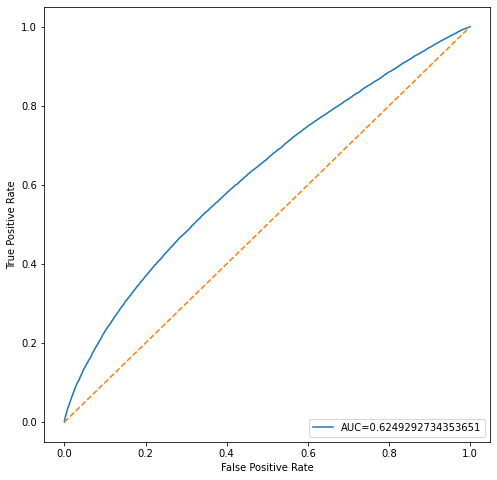

In [ ]:
samePairProbs = (1 / np.array(samePairCosinSimilarities)) * 100
diffPairProbs = (1 / np.array(diffPairCosinSimilarities)) * 100
allProbs = np.concatenate((samePairProbs, diffPairProbs), axis=0)
y = np.concatenate((np.ones(samePairProbs.shape), np.zeros(diffPairProbs.shape)), axis=0)

fpr, tpr, _ = roc_curve(y,  allProbs)
auc = roc_auc_score(y, allProbs)

#create ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [ ]:
np.count_nonzero(samePairCosinSimilarities >= auc)

35704

In [ ]:
np.count_nonzero(diffPairCosinSimilarities >= auc)

35704